In [1]:
# This file is part of the ADS Parameter Fitting project.
# must be used under ADS integrated Python env (A)
# namely, ..\ADS_install_path\tools\python\python.exe --> Python 3.13.2
# TODO: whole script is run in Jupyter because ADS python ADI only
# supports IPython kernel !!!

# packages to build DIR env
import os, json
# set ads dict: HPEESOF_DIR and home director : HOME
os.environ['HPEESOF_DIR'] = 'D:/ADS/install'
os.environ['HOME'] = 'D:/ADS/dir'

# # packages to multiprocessing
# # add current working directory
# import sys
# cur_path_nn = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting_local/IV_param_regression/NN_training"
# sys.path.append(cur_path_nn)

# packages to import ADS
from keysight.ads import de
from keysight.ads.de import db_uu as db
from keysight.edatoolbox import ads
import keysight.ads.dataset as dataset
from keysight.edatoolbox import util
from pathlib import Path
from IPython.core import getipython

# packages for model inference
from infer_sup_packg import *

import warnings
warnings.filterwarnings(
    "ignore",
    message="Conversion of an array with ndim > 0 to a scalar is deprecated"
)

In [2]:
# necessary class and functions for ADS simulation

class PyADS():
    def __init__(self):
        self.HPEESOF_DIR = 'D:/ADS/install'
        self.HOME = 'D:/ADS/dir'
        self.cur_workspace_path = None
        self.workspace = None
        self.cur_library_name = None
        self.library = None
        self.cur_design_name = None
        self.design = None

    def create_and_open_an_empty_workspace(self, workspace_path: str):
    # example : workspace_path = "C:/ADS_Python_Tutorials/tutorial1_wrk"
    # Ensure there isn't already a workspace open
        if de.workspace_is_open():
            de.close_workspace()
    
        # Cannot create a workspace if the directory already exists
        if os.path.exists(workspace_path):
            raise RuntimeError(f"Workspace directory already exists: {workspace_path}")
    
        # Create the workspace
        workspace = de.create_workspace(workspace_path)
        # Open the workspace
        workspace.open()
        # Return the open workspace and close when it finished
        return workspace
    
    def create_a_library_and_add_it_to_the_workspace(self, workspace: de.Workspace, library_name: str) -> None:
        #assert workspace.path is not None
        # Libraries can only be added to an open workspace
        assert workspace.is_open
        # We'll create a library in the directory of the workspace
        library_path = workspace.path / library_name
        # Create the library
        de.create_new_library(library_name, library_path)
        # And add it to the workspace (update lib.defs)
        workspace.add_library(library_name, library_path, de.LibraryMode.SHARED)
        lib=workspace.open_library(library_name,library_path,de.LibraryMode.SHARED)
        return lib

    # @timeout_thread_soft(20) # 20s timeout
    def schematic_simulation(self, workspace_path: str, library_name: str, design_name: str, instance_name: str, var_dict: dict, vgs_bias_param_sweep_name: str, vds_bias_param_sweep_name: str, vgs_bias_simulation_name: str, vds_bias_simulation_name: str, verilog_a_dir:str = None) -> None:
        ''' Load Path and files, Edit the design variables, Simulate the design, and return the dataset '''

        # test timeout
        # random_number = random.random()
        # time.sleep(13) if random_number >= 0.5 else time.sleep(0.5)

        # >> Load Path and files
        if not os.path.exists(workspace_path):
            raise RuntimeError(f"Workspace directory doesn't exist: {workspace_path}")
        if de.workspace_is_open():
            de.close_workspace()
        
        # Open the workspace
        # if (not self.workspace) or (self.cur_workspace_path != workspace_path):
        self.workspace = de.open_workspace(workspace_path)
        self.cur_workspace_path = workspace_path
        # Open the library
        # if (not self.library) or (self.cur_library_name != library_name):
        self.library = self.workspace.open_library(lib_name=library_name, mode=de.LibraryMode.SHARED)
        self.cur_library_name = library_name
        # Open the design
        # if (not self.design) or (self.cur_design_name != design_name):
        self.design = db.open_design((library_name, design_name, "schematic"), db.DesignMode.APPEND)
        self.cur_design_name = design_name

        # >> Edit the design variables
        # edit VAR
        v = self.design.get_instance(inst_name=instance_name)
        assert v.is_var_instance
        for var_name in var_dict:
            v.vars[var_name] = var_dict[var_name]
        # Save the design
        self.design.save_design()
        # Simulate the design
        output_dir = os.path.join(self.workspace.path, "output")
        netlist_file = os.path.join(output_dir, "data_gen.ckt")
        output_file =  os.path.join(output_dir, "data_gen.ckt.out")
        # create the simulation output directory
        util.safe_makedirs(output_dir)

        # >> Simulate and return the dataset
        # ipython = getipython.get_ipython()
        # if ipython is None:
        #     print("The remaining portion of the script must be run in an IPython environment. Exiting.")
        #     return
        # capture the netlist in a string
        netlist = self.design.generate_netlist()
        # access to the simulator object to run netlists
        simulator = ads.CircuitSimulator()
        # run the netlist, this will block output
        simulator.run_netlist(netlist, output_dir=output_dir, netlist_file=netlist_file, output_file=output_file, verilog_dir=verilog_a_dir)
        output_data = dataset.open(Path(os.path.join(output_dir, f"{design_name}.ds")))
        
        # >> return data in pandas DataFrame format
        # <class 'pandas.core.frame.DataFrame'>
        data_ids_vds = output_data[f'{vgs_bias_param_sweep_name}.{vgs_bias_simulation_name}.DC'].to_dataframe().reset_index()
        data_ids_vgs = output_data[f'{vds_bias_param_sweep_name}.{vds_bias_simulation_name}.DC'].to_dataframe().reset_index()
        return data_ids_vds, data_ids_vgs
    


    def dataset_reshape(self, pd_data_IV: pd.DataFrame, pd_data_gm: pd.DataFrame, IV_dimension: list, gm_dimension: list, var_dict: dict):
        ''' reshape the dataset into desired input matrix and output vector '''
        IV_row_count = IV_dimension[0] # Vgs
        IV_col_count = IV_dimension[1] # Vds
        gm_row_count = gm_dimension[0] # Vds
        gm_col_count = gm_dimension[1] # Vgs

        output_x_IV = np.empty((IV_row_count, IV_col_count),dtype=np.float64)
        output_x_gm = np.empty((gm_row_count, gm_col_count),dtype=np.float64)
        output_y = np.empty((len(var_dict), 1),dtype=np.float64)

        IV_row = pd_data_IV["VGS"].drop_duplicates().sort_values(ascending=True).tolist() # attention here: must be descending order
        gm_row = pd_data_gm["VDS"].drop_duplicates().sort_values(ascending=True).tolist()

        for index,row_value in enumerate(IV_row):
            output_x_IV[index, :] = pd_data_IV.loc[pd_data_IV['VGS'] == row_value, 'IDS.i'].to_numpy()
        for index,row_value in enumerate(gm_row):
            output_x_gm[index, :] = pd_data_gm.loc[pd_data_gm['VDS'] == row_value, 'IDS.i'].to_numpy()
        for index, item in enumerate(var_dict):
            output_y[index, 0] = var_dict[item]

        return output_x_IV, output_x_gm, output_y
    

def param_random_generator(param_range: dict):
    ''' generate a random parameter set for the HEMT model '''
    # define the parameter range
    # param_range = {
    #     'VOFF': (-1.2, 2.6),
    #     'U0': (0, 2.2),
    #     'NS0ACCS': (1e15, 1e20),
    #     'NFACTOR': (0.1, 5),
    #     'ETA0': (0, 1),
    #     'VSAT': (5e4, 1e7),
    #     'VDSCALE': (0.5, 1e6),
    #     'CDSCD': (1e-5, 0.75),
    #     'LAMBDA': (0, 0.2),
    #     'MEXPACCD': (0.05, 12),
    #     'DELTA': (2, 100)
    # }
    # generate random parameters
    var_dict = {key: str(np.random.uniform(low=val[0], high=val[1])) for key, val in param_range.items()}
    return var_dict

def init_h5_file(h5_path, x_iv_shape, x_gm_shape, y_shape,
                 dtype_x=np.float64, dtype_y=np.float64):
    with h5py.File(h5_path, 'w') as f:
        # X: [num_samples, m, n]
        f.create_dataset(
            'X_iv',
            shape=(0, x_iv_shape[0], x_iv_shape[1]),
            maxshape=(None, x_iv_shape[0], x_iv_shape[1]),
            dtype=dtype_x
        )
        f.create_dataset(
            'X_gm',
            shape=(0, x_gm_shape[0], x_gm_shape[1]),
            maxshape=(None, x_gm_shape[0], x_gm_shape[1]),
            dtype=dtype_x
        )
        # Y: [num_samples, y_len]
        f.create_dataset(
            'Y',
            shape=(0, y_shape[0], 1),
            maxshape=(None, y_shape[0], 1),
            dtype=dtype_y
        )

def append_to_h5(h5_path, x_iv_new, x_gm_new, y_new):
    x_iv_new = np.asarray(x_iv_new, dtype=np.float64)
    x_gm_new = np.asarray(x_gm_new, dtype=np.float64)
    y_new = np.asarray(y_new, dtype=np.float64)

    # 确保 y_new 是二维 (batch_size, y_len)
    if y_new.ndim == 2:
        y_new = y_new.reshape(-1, 1)
    else:
        raise RuntimeError(f"y_new must be vector, but got shape {y_new.shape}")

    with h5py.File(h5_path, 'a') as f:
        ds_x_iv = f['X_iv']
        ds_x_gm = f['X_gm']
        ds_y = f['Y']

        cur_len = ds_x_iv.shape[0]
        new_len = cur_len + 1

        # 扩展
        ds_x_iv.resize(new_len, axis=0)
        ds_x_gm.resize(new_len, axis=0)
        ds_y.resize(new_len, axis=0)

        # 赋值
        ds_x_iv[cur_len:new_len, :, :] = x_iv_new
        ds_x_gm[cur_len:new_len, :, :] = x_gm_new
        ds_y[cur_len:new_len, :, :] = y_new


def singel_process_iteration_data_gen2h5(workspace_path: str, 
                                         validate_dict: dict, 
                                         library_name: str, 
                                         design_name: str, 
                                         instance_name: str, 
                                         param_range: dict, 
                                         vgs_bias_param_sweep_name: str, 
                                         vds_bias_param_sweep_name: str, 
                                         vgs_bias_simulation_name: str, 
                                         vds_bias_simulation_name: str, 
                                         data_shape: list, 
                                         iteration_num: int, 
                                         process_id: int, 
                                         save_path: str, 
                                         verilog_a_dir: str = None, 
                                         new_start: bool = True, 
                                         old_stop_index: int = 0, 
                                         dtype_x=np.float64, dtype_y=np.float64):
    ''' generate dataset in single process iteration '''
    # create an instance of the PyADS class
    ads_ctrl = PyADS()
    X_iv_shape = data_shape[0]
    X_gm_shape = data_shape[1]
    Y_shape = data_shape[2]
    num_sampling = len(validate_dict['VSAT']) if type(validate_dict['VSAT'])!=str else 1
    iteration_num = num_sampling

    # init h5 file
    if new_start:
        init_h5_file(f"{save_path}\\validate.h5", X_iv_shape, X_gm_shape, Y_shape)
    # on cvae + rand mode, transform a big dict into several small dict available for iterator
    validate_dict_list = None
    if num_sampling != 1:
        validate_dict_list = [dict(zip(validate_dict.keys(), values)) for values in zip(*validate_dict.values())]

    for i in range(num_sampling) if new_start else range(old_stop_index, iteration_num):
        while True:
            try:
                start_time = time.time()
                if validate_dict:
                    var_dict = validate_dict if not validate_dict_list else validate_dict_list[i]
                else:
                # var_dict = param_random_generator(param_range)
                    var_dict = param_random_generator_log(param_range) # use log-uniform distribution based generator
                pd_data_vgs_bias, pd_data_gm = ads_ctrl.schematic_simulation(
                    workspace_path,
                    library_name,
                    design_name,
                    instance_name,
                    var_dict,
                    vgs_bias_param_sweep_name,
                    vds_bias_param_sweep_name,
                    vgs_bias_simulation_name,
                    vds_bias_simulation_name,
                    verilog_a_dir
                )
                X_iv, X_gm, y = ads_ctrl.dataset_reshape(pd_data_vgs_bias, pd_data_gm, X_iv_shape, X_gm_shape, var_dict)
                end_time = time.time()
                print(f" >> Process {process_id} :: Loop {i+1}/{iteration_num} :: used time: {round(end_time - start_time, 2)} s")
                try:
                    if not validate_dict:
                        append_to_h5(f"{save_path}\\dataset_process_{process_id}.h5", X_iv, X_gm, y)
                    else:
                        append_to_h5(f"{save_path}\\validate.h5", X_iv, X_gm, y)
                except:
                    print(f"【ERROR】Error appending data in process {process_id} at iteration {i + 1}")
                break

            # except TimeoutError:
            #     end_time = time.time()
            #     print(f' >> Process {process_id} :: Loop {i + 1}/{iteration_num} [Failed because Timeout] :: used time:', round(end_time - start_time, 2), 's', file=sys.stderr, flush=True)
            #     time.sleep(3)
            #     ads_ctrl.close()
            #     time.sleep(10)
            #     continue
            except:
                end_time = time.time()
                print(f' >> Process {process_id} :: Loop {i + 1}/{iteration_num} [Failed because cannot converge] :: used time:', round(end_time - start_time, 2), 's')
                time.sleep(1)
                # ads_ctrl.close()
                # time.sleep(2)
                continue

In [3]:
# For ADS
# DEFINE VARIABLES

workspace_path = "E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Simulation\\ADS\\ASM_HEMT1_wrk_1_Jia"
verilog_a_dir = workspace_path + "\\veriloga"
validate_dict = None
library_name = "IAF_pGaN_lib"
design_name = "gs66508bv1_Pytest_simple_paramset_symmetric"
instance_name = "IV"
var_dict_default = {'VOFF':'-4.1', 'U0':'0.4', 'NS0ACCS':'5e+16', 'NFACTOR':'0', 'ETA0':'1e-9', 'VSAT':'1.9e5', 'VDSCALE':'5', 'CDSCD':'0.05', 'LAMBDA':'0.01', 'MEXPACCD':'2', 'DELTA':'2', 'UA':'3e-9', 'UB':'3e-18', 'U0ACCS':'0.17'}
param_range = {
        'VOFF': (-1.2, 2.6),
        'U0': (0, 2.2),
        'NS0ACCS': (1e15, 1e20),
        'NFACTOR': (0.1, 5),
        'ETA0': (0, 1),
        'VSAT': (5e4, 1e7),
        'VDSCALE': (0.5, 1e6),
        'CDSCD': (1e-5, 0.75),
        'LAMBDA': (0, 0.2),
        'MEXPACCD': (0.05, 12),
        'DELTA': (2, 100),
        'UA': (1e-10, 1e-8),
        'UB': (1e-21, 3e-16),
        'U0ACCS': (5e-2, 0.25)
    }

X_iv_shape = [7,121]
X_gm_shape = [10,71]
Y_shape = [len(param_range),1]
X_iv_dict = {
    'goal': "X_iv",
    'row_range': (1, 7),
    'col_range': (-3.5, 8.5),
    'row_num': X_iv_shape[0],
    'col_num': X_iv_shape[1]
}
X_gm_dict = {
    'goal': "X_gm",
    'row_range': (1, 10),
    'col_range': (0, 7),
    'row_num': X_gm_shape[0],
    'col_num': X_gm_shape[1]
}


X_dict = {
    'X_iv': X_iv_dict,
    'X_gm': X_gm_dict
}
data_shape = [X_iv_shape, X_gm_shape, Y_shape]
vgs_bias_param_sweep_name = 'Sweep_vgs'
vds_bias_param_sweep_name = 'Sweep_vds'
vgs_bias_simulation_name = 'Output'
vds_bias_simulation_name = 'Transfer'
iteration_num = 1000
process_id = 1
data_save_path = "E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\dataset\\temp_generated"


# ------------------------------------------------------------------
# For NN model inference

python_path = r"D:/Miniconda/envs/DL/python.exe"  # model based python path
script_dir  = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\code\\training\\cvae_Unidi_CNN" # path of code
# script_dir  = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\code\\training\\pure_MLP_Unidi" # baseline
code_file_name = "main.py"
training_data_path   = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\dataset\\training\\Uni_log_2Channel_mask1_2.h5"  # path of training dataset

meas_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\dataset\\training\\meas_smoothed_Uni_2Channel_wide.h5"

output_csv_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\dataset\\temp_generated\\pred_7row.csv"



In [4]:
'''single model inference config'''

# CVAE model
model_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\model\\cvae_Unidi_14param_2channel\\version_2_4"
# baseline
# model_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\temp_Unidi_pureMLP_2channel\\version_1_1" 

# basic params
inference_data_path = meas_path # path of inference dataset
# inference_data_path = training_data_path # path of inference dataset
inference_data_index = "None" #  from 0 to 9999
# "None"    : for 1. single input with shape (2,6,121)
#                 2. multile input with shaple (N,2,6,121)
# str(int)  : for single input with shape (N,2,6,121)
single_input_mode = bool(True)
cvae_ena = True
cvae_mode = 'rand'
num_sampling = 1000 # only used when cvae_mode = 'rand'
dropout_enale = False

 >> Start model inference...
[log] tee initialized at 2026-01-11 20:02:42 -> runs_dual\session_20260111-200242.log
Using CUDA device 0: NVIDIA GeForce RTX 4060 Laptop GPU

--- Solution Statistics (for first input) ---
  VOFF     : mean=1.898  std=0.02554
  U0       : mean=0.2222  std=0.006771
  NS0ACCS  : mean=5.311e+17  std=2.597e+16
  NFACTOR  : mean=0.8557  std=0.026
  ETA0     : mean=0.1644  std=0.01129
  VSAT     : mean=1.271e+05  std=6567
  VDSCALE  : mean=1.995  std=0.1875
  CDSCD    : mean=0.0003542  std=2.649e-05
  LAMBDA   : mean=0.07234  std=0.001295
  MEXPACCD : mean=2.672  std=0.11
  DELTA    : mean=8.839  std=0.2758
  UA       : mean=5.43e-09  std=1.623e-10
  UB       : mean=3.358e-21  std=3.799e-22
  U0ACCS   : mean=0.07464  std=0.001192

Saved all 1000 sampled solutions to E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\dataset\\temp_generated\\pred_7row.csv
Saved infere

e:\personal_Data\Document of School\Uni Stuttgart\Masterarbeit\Code\param_regression\ADS_Parameter_Fitting\IV_param_regression\NN_training\code\inference\infer_sup_packg.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[index][fig_col].legend()


saved figure under path : C:\Users\97427\Desktop\figure_IV_full.svg 
saved figure under path : C:\Users\97427\Desktop\figure_IV_shrink.svg 

 >> Save the best case in ADS project...
 >> Process 1 :: Loop 1/1 :: used time: 1.52 s


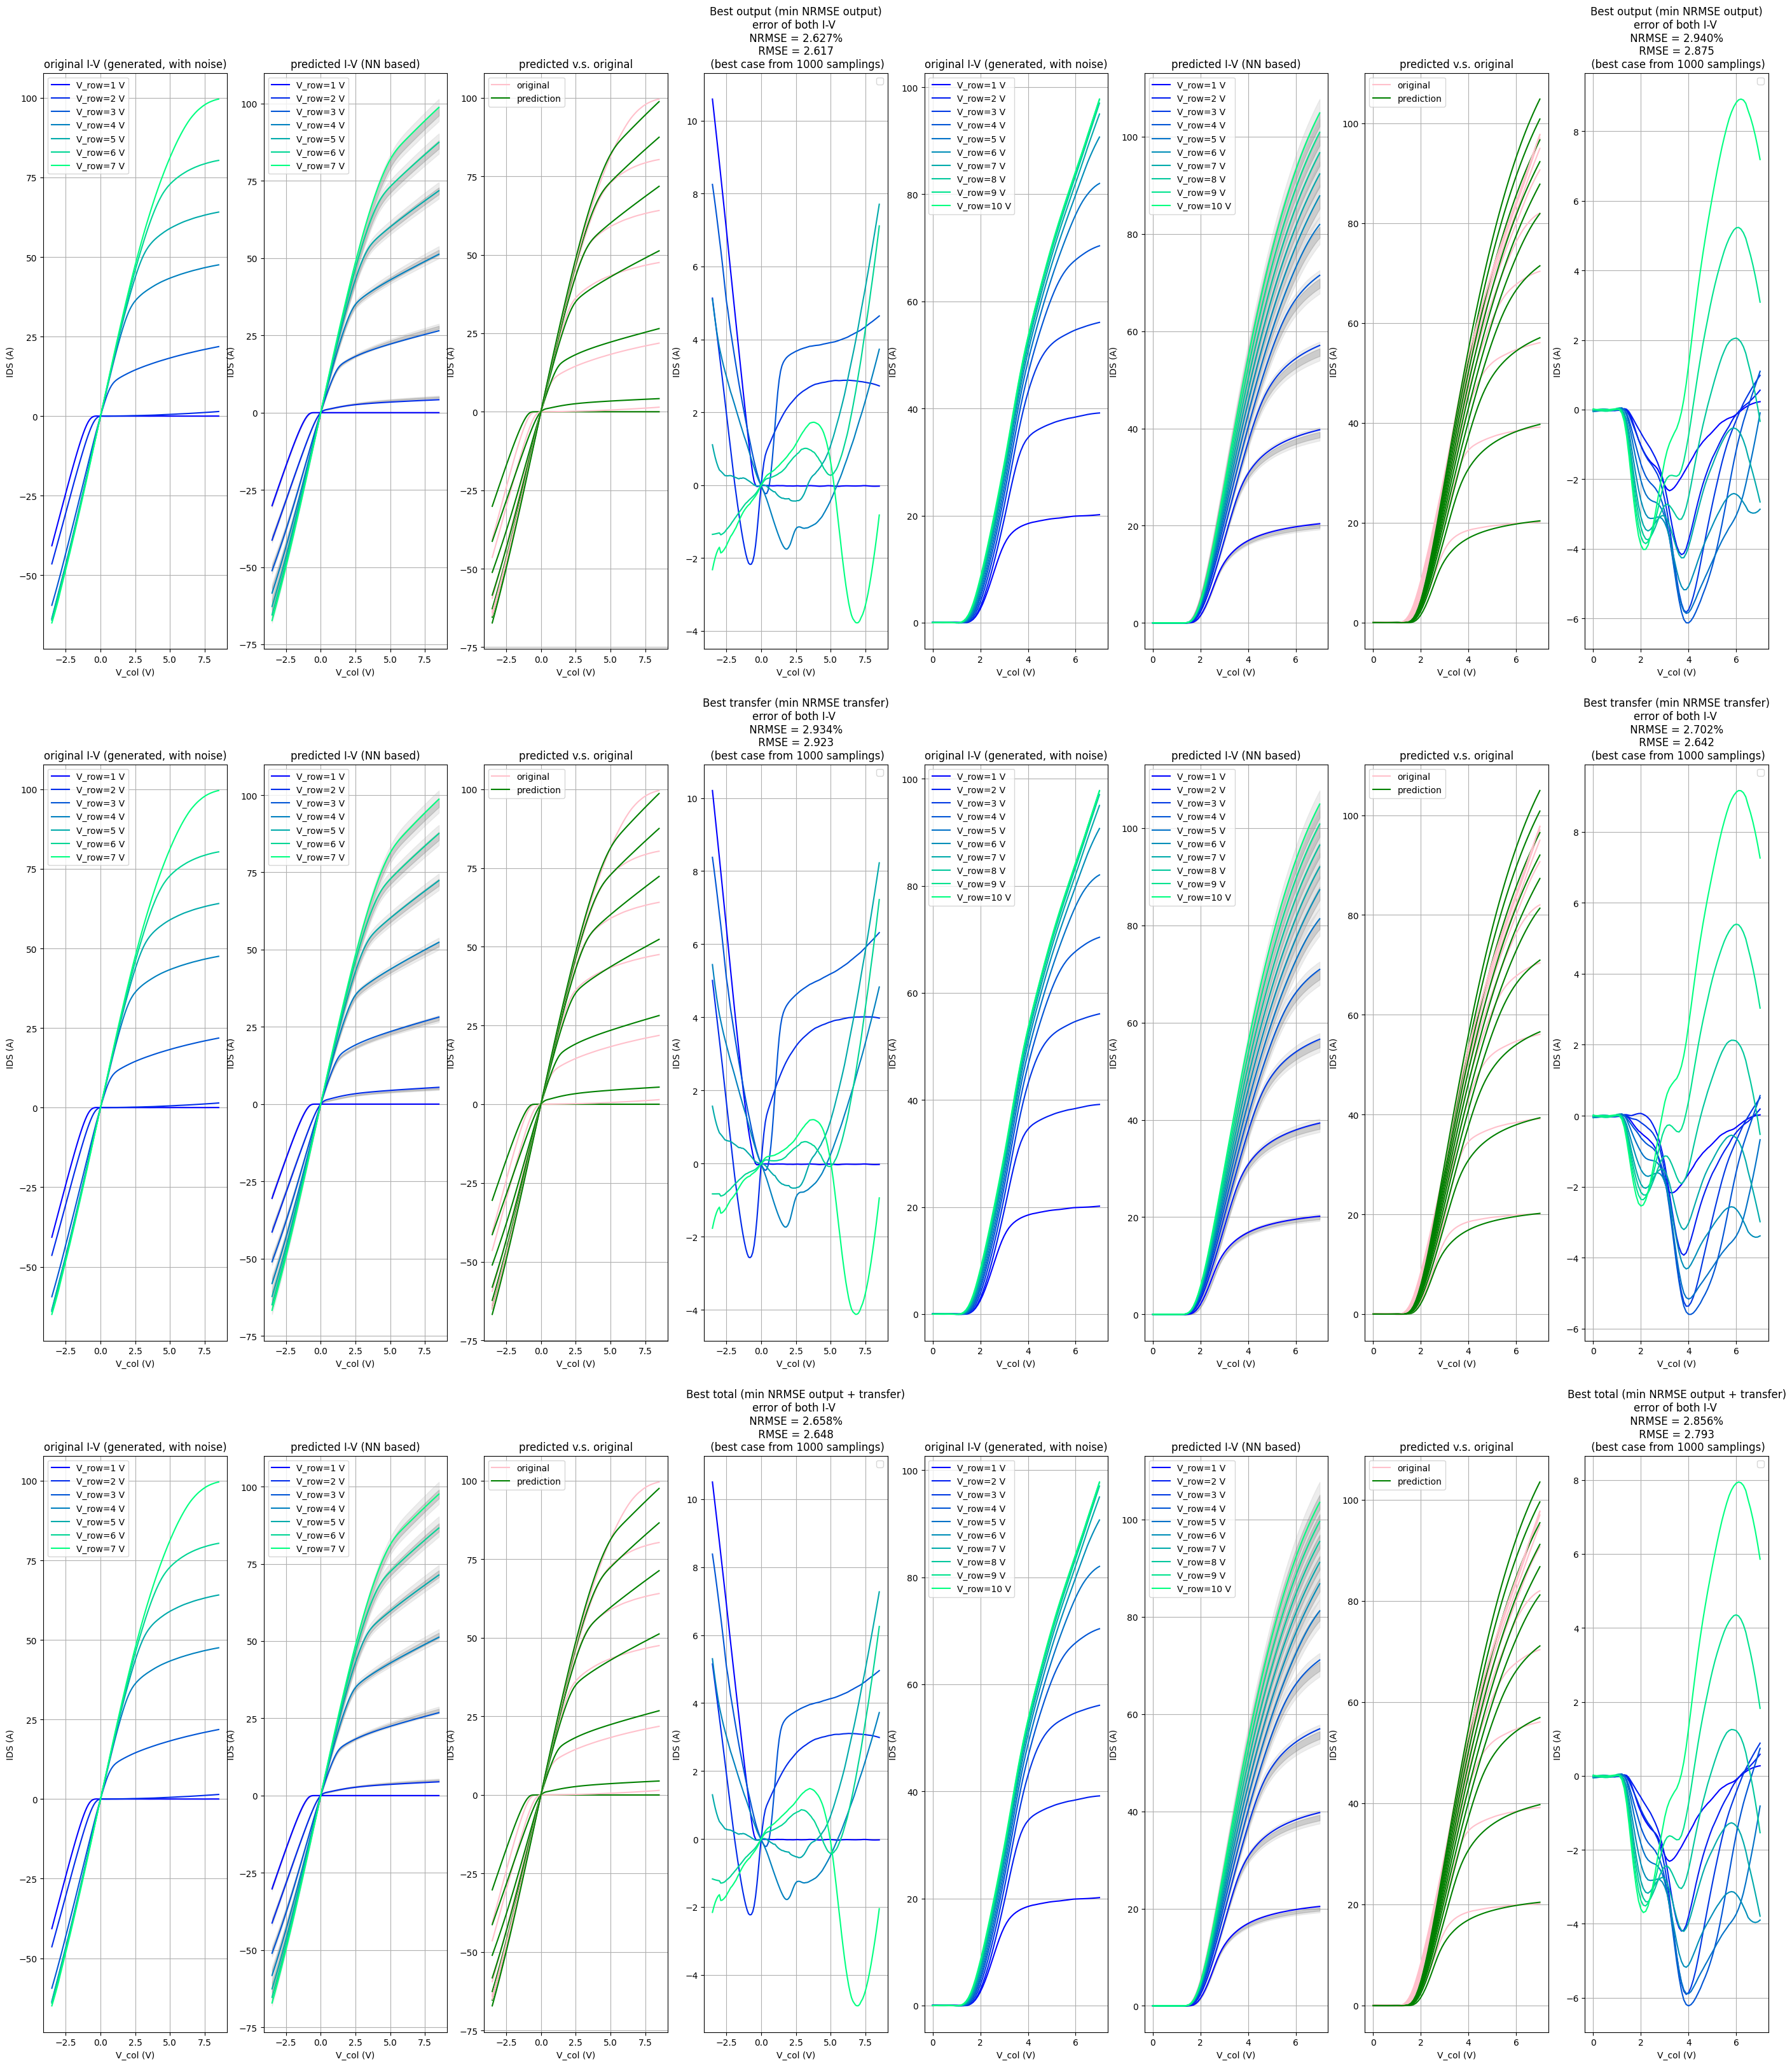

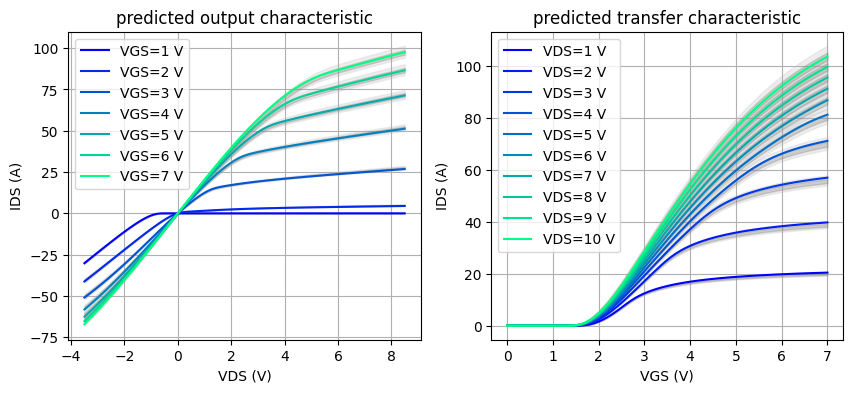

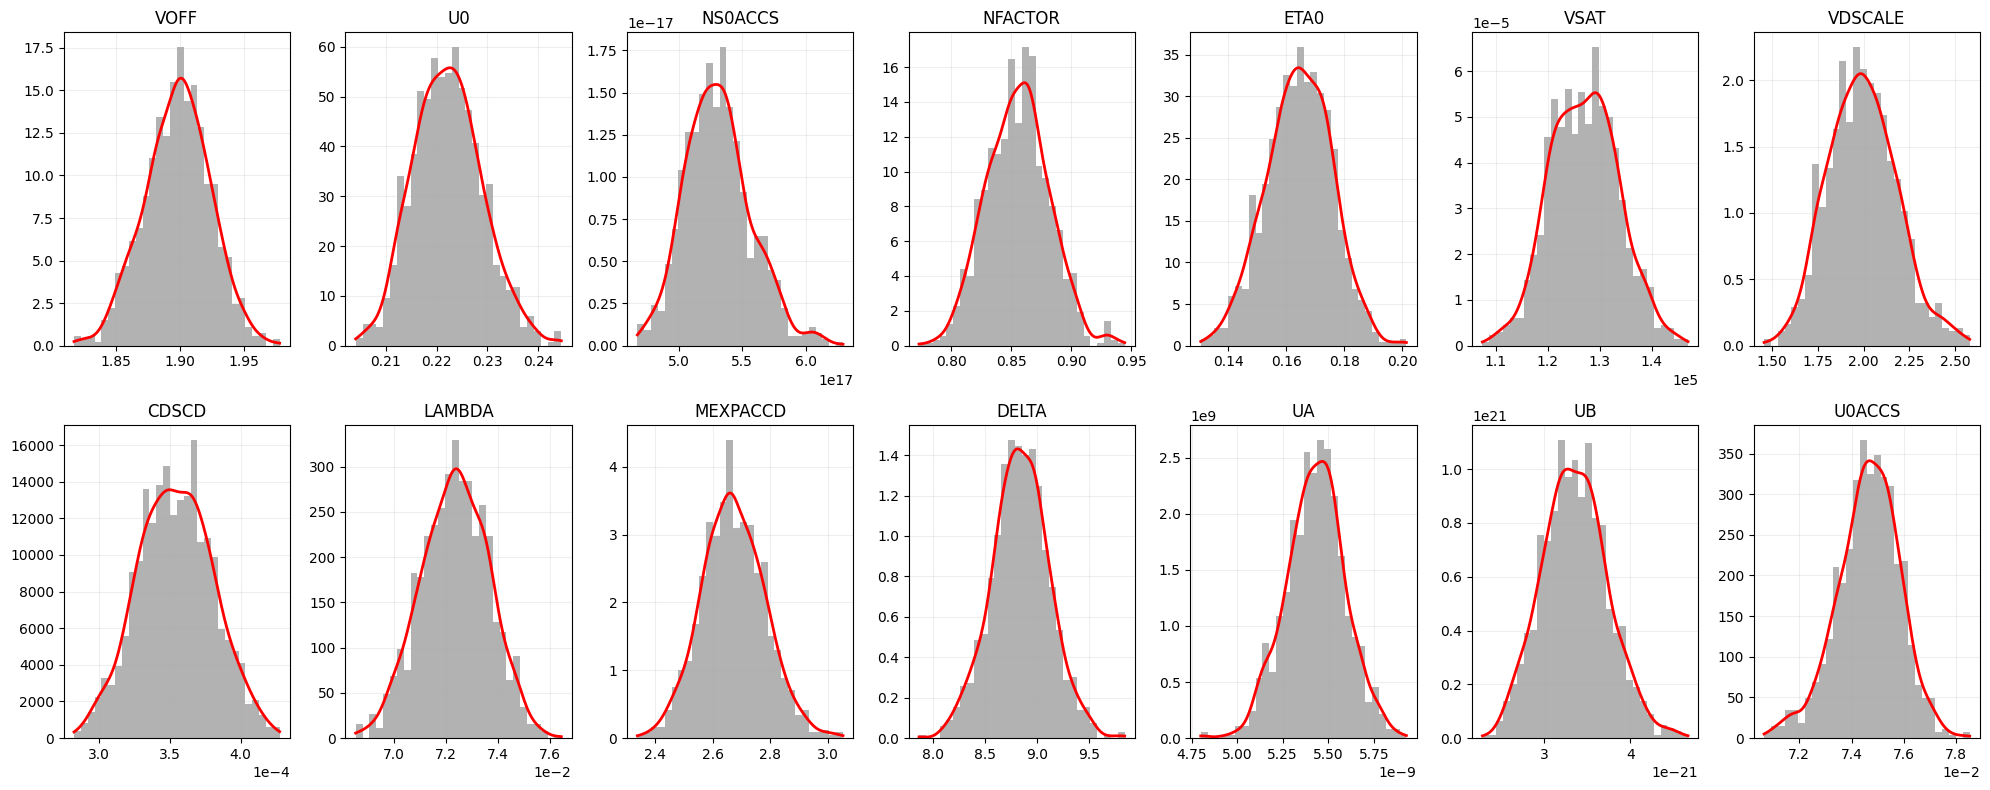

In [5]:
'''single model inference processing ...'''

# Model inference
print(" >> Start model inference...")
# var_dict = model_inference(
#     python_path=python_path,
#     script_dir=script_dir,
#     code_file_name="asm_hemt_2stage_dnn.py" if not cvae_ena else "asm_hemt_cvae.py",
#     model_path=model_path,
#     inference_data_path=inference_data_path,
#     inference_data_index=inference_data_index,
#     output_csv_path=output_csv_path,
#     single_input_mode=single_input_mode,
#     cvae_ena=cvae_ena,
#     cvae_mode=cvae_mode,
#     num_sampling=num_sampling
# )
var_dict = model_inference(
    python_path=python_path,
    script_dir=script_dir,
    code_file_name=code_file_name,
    model_path=model_path,
    inference_data_path=inference_data_path,
    inference_data_index=inference_data_index,
    output_csv_path=output_csv_path,
    single_input_mode=single_input_mode,
    cvae_ena=cvae_ena,
    cvae_mode=cvae_mode,
    num_sampling=num_sampling,
    dropout_enable=dropout_enale,
)

# range correction
print(" >> Start output range correction...")
row_def = num_sampling if cvae_ena and cvae_mode=='rand' else 2
val_matrix = np.full((row_def, len(param_range)), 'OK', dtype="<U10")
var_matrix = np.full((row_def, len(param_range)), 0.0, dtype=np.float64)
for index,key in enumerate(param_range):
    var_matrix[:,index] = np.array(var_dict[key], dtype=float)
for col,key in enumerate(param_range):
    (low,high) = param_range[key]
    low_mask = var_matrix[:,col] < low
    high_mask = var_matrix[:,col] > high
    val_matrix[low_mask,col] = 'Underflow'
    var_matrix[low_mask,col] = low
    val_matrix[high_mask,col] = 'Overflow'
    var_matrix[high_mask,col] = high
    var_dict[key] = var_matrix[:,col].astype(str)
if ('Underflow' in val_matrix) or ('Overflow' in val_matrix):
    print('\t【VAL】Show the over-bounded matrix: \n', val_matrix)
else:
    print('\t【VAL】No element is over-bounded')
    
# print(var_dict)
    
# main function to run the data generation - single process
print(" >> Start validate in ADS...")
singel_process_iteration_data_gen2h5(
            workspace_path=workspace_path,
            validate_dict=var_dict,
            library_name=library_name,
            design_name=design_name,
            instance_name=instance_name,
            param_range=param_range,
            vgs_bias_param_sweep_name=vgs_bias_param_sweep_name,
            vds_bias_param_sweep_name=vds_bias_param_sweep_name,
            vgs_bias_simulation_name=vgs_bias_simulation_name,
            vds_bias_simulation_name=vds_bias_simulation_name,
            data_shape=data_shape,
            iteration_num=1,
            process_id=1,
            save_path=data_save_path,
            verilog_a_dir=verilog_a_dir)


# plot error between prediction and original I-V data
print(" >> Start plot error...")
best_idx_iv, best_idx_gm, best_idx_total = plot_error_2channel(inference_data_path, data_save_path, inference_data_index, var_dict, val_matrix, X_dict, output_csv_path)
best_idx_iv, best_idx_gm, best_idx_total = plot_error_2channel(inference_data_path, data_save_path, inference_data_index, var_dict, val_matrix, X_dict, output_csv_path, shrink=True, size=(10,4))

# fig 2 :: hist
if cvae_ena and cvae_mode == 'rand' and num_sampling > 1:
    odd = len(param_range)%2!=0
    size  = round((len(param_range))/2)
    fig, ax = plt.subplots(2, size, figsize=(20, 8)) 

    for index, key in enumerate(var_dict):
        data = list(map(float, var_dict[key]))
        kde = gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 3000)
        y_vals = kde(x_vals)
        coordinate = [0, index] if ((index + 1) <= size) else [1, index - size]
        ax[coordinate[0], coordinate[1]].hist(data, bins = 30, density=True, color = 'grey', alpha = 0.6)
        ax[coordinate[0], coordinate[1]].set_title(key)
        ax[coordinate[0], coordinate[1]].plot(x_vals, y_vals, linewidth=2, label="KDE curve", color = 'red')
        ax[coordinate[0], coordinate[1]].grid(True, alpha=0.2)
        ax[coordinate[0], coordinate[1]].ticklabel_format(style='sci', scilimits=(-2,3), axis='x')
    if odd:
        fig.delaxes(ax[-1, -1])
    plt.tight_layout()
    fig.savefig("C:\\Users\\97427\\Desktop\\figure_hist.svg", bbox_inches='tight', format='svg')

# finnaly run the best inference case once again 
# in order to save correspondings param in ADS project file
if inference_data_index == "None":
    print('\n >> Save the best case in ADS project...')
    best_var_dict = {k: str(v[best_idx_total]) for k, v in var_dict.items()}
    singel_process_iteration_data_gen2h5(
                workspace_path=workspace_path,
                validate_dict=best_var_dict,
                library_name=library_name,
                design_name=design_name,
                instance_name=instance_name,
                param_range=param_range,
                vgs_bias_param_sweep_name=vgs_bias_param_sweep_name,
                vds_bias_param_sweep_name=vds_bias_param_sweep_name,
                vgs_bias_simulation_name=vgs_bias_simulation_name,
                vds_bias_simulation_name=vds_bias_simulation_name,
                data_shape=data_shape,
                iteration_num=1,
                process_id=1,
                save_path=data_save_path,
                verilog_a_dir=verilog_a_dir)

# {'VOFF':'1.785', 'U0':'0.424', 'NS0ACCS':'2e+17', 'NFACTOR':'1', 'ETA0':'0.06', 'VSAT':'8e+4', 'VDSCALE':'5', 'CDSCD':'0.1', 'LAMBDA':'0.01', 'MEXPACCD':'1.5', 'DELTA':'3'}

In [ ]:
'''TTO inference processing ...'''

proxy_path = r"E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/temp_Unidi_cvae_14param_2channel/proxy_dual_bigger"

# TTO inference
var_dict = TTO_infer(
    python_path=python_path,
    script_dir=script_dir,
    code_file_name="infer_tto_strict.py",
    model_path=model_path,
    proxy_path=proxy_path,
    infer_data_path=inference_data_path,
    infer_data_index='None',
    steps=1000,
    lr=0.01
)

print(var_dict)


# range correction
print(" >> Start output range correction...")
row_def = 2 if cvae_ena and cvae_mode=='rand' else 1
val_matrix = np.full((row_def, len(param_range)), 'OK', dtype="<U10")
var_matrix = np.full((row_def, len(param_range)), 0.0, dtype=np.float64)
for index,key in enumerate(param_range):
    var_matrix[:,index] = np.array(var_dict[key], dtype=float)
for col,key in enumerate(param_range):
    (low,high) = param_range[key]
    low_mask = var_matrix[:,col] < low
    high_mask = var_matrix[:,col] > high
    val_matrix[low_mask,col] = 'Underflow'
    var_matrix[low_mask,col] = low
    val_matrix[high_mask,col] = 'Overflow'
    var_matrix[high_mask,col] = high
    var_dict[key] = var_matrix[:,col].astype(str)
if ('Underflow' in val_matrix) or ('Overflow' in val_matrix):
    print('\t【VAL】Show the over-bounded matrix: \n', val_matrix)
else:
    print('\t【VAL】No element is over-bounded')

print(var_dict)

# main function to run the data generation - single process
print(" >> Start validate in ADS...")
singel_process_iteration_data_gen2h5(
            workspace_path=workspace_path,
            validate_dict=var_dict,
            library_name=library_name,
            design_name=design_name,
            instance_name=instance_name,
            param_range=param_range,
            vgs_bias_param_sweep_name=vgs_bias_param_sweep_name,
            vds_bias_param_sweep_name=vds_bias_param_sweep_name,
            vgs_bias_simulation_name=vgs_bias_simulation_name,
            vds_bias_simulation_name=vds_bias_simulation_name,
            data_shape=data_shape,
            iteration_num=1,
            process_id=1,
            save_path=data_save_path,
            verilog_a_dir=verilog_a_dir)


# plot error between prediction and original I-V data
print(" >> Start plot error...")
best_idx_iv, best_idx_gm, best_idx_total = plot_error_2channel(inference_data_path, data_save_path, inference_data_index, var_dict, val_matrix, X_dict, output_csv_path)



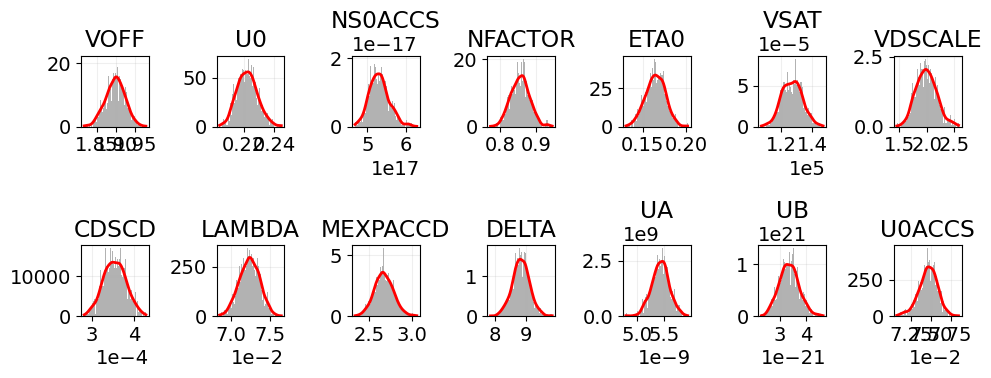

In [20]:
# fig 2 :: hist
if cvae_ena and cvae_mode == 'rand' and num_sampling > 1:
    odd = len(param_range)%2!=0
    size  = round((len(param_range))/2)
    fig, ax = plt.subplots(2, size, figsize=(10, 4)) 

    for index, key in enumerate(var_dict):
        data = list(map(float, var_dict[key]))
        kde = gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 3000)
        y_vals = kde(x_vals)
        coordinate = [0, index] if ((index + 1) <= size) else [1, index - size]
        ax[coordinate[0], coordinate[1]].hist(data, bins = 80, density=True, color = 'grey', alpha = 0.6)
        ax[coordinate[0], coordinate[1]].set_title(key)
        ax[coordinate[0], coordinate[1]].plot(x_vals, y_vals, linewidth=2, label="KDE curve", color = 'red')
        ax[coordinate[0], coordinate[1]].grid(True, alpha=0.2)
        ax[coordinate[0], coordinate[1]].ticklabel_format(style='sci', scilimits=(-2,3), axis='x')
    if odd:
        fig.delaxes(ax[-1, -1])
    plt.tight_layout()
    fig.savefig("C:\\Users\\97427\\Desktop\\figure.svg", bbox_inches='tight', format='svg')

size of measured Output feature:  (1, 7, 121)
size of measured Transfer feature:  (1, 10, 71)
size of predicted Output feature:  (1, 7, 121)
size of predicted Transfer feature:  (1, 10, 71)
saved figure under path : C:\Users\97427\Desktop\figure.svg 


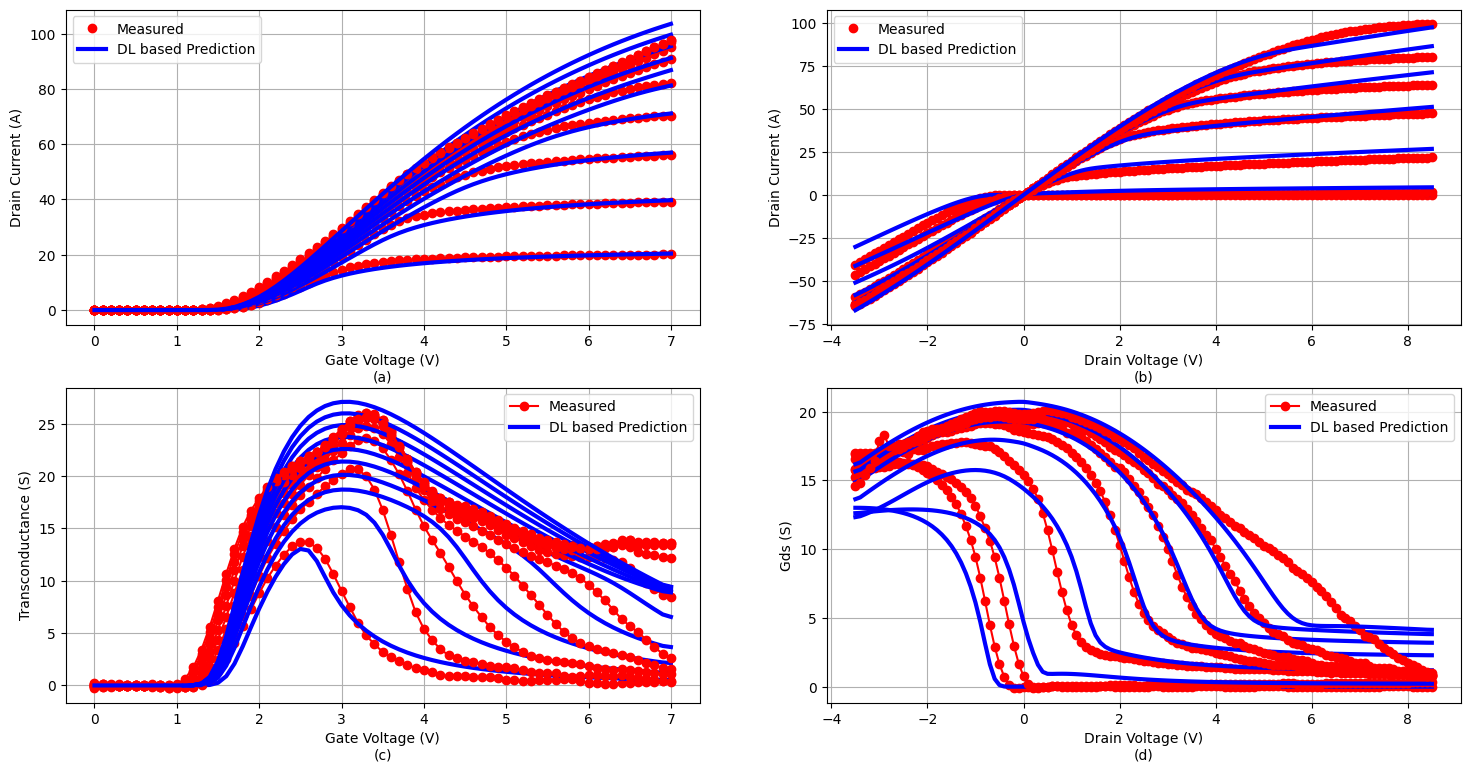

In [5]:
# fig 3 :: better result representation


ref_Output = r"E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/ref_data/meas_smoothed_Uni_Output.h5"
ref_Transfer = r"E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/ref_data/meas_smoothed_Uni_Transfer_wide.h5"
X_origin_o = h5py.File(ref_Output, 'r')
X_origin_t = h5py.File(ref_Transfer, 'r')
X_pred_mlp = h5py.File(f"{data_save_path}\\validate_uni_mlp.h5", 'r')
X_pred = h5py.File(f"{data_save_path}\\validate.h5", 'r')
vgs_bias_x_axis = np.linspace(min(X_iv_dict['col_range']), max(X_iv_dict['col_range']), X_iv_shape[1])
vds_bias_x_axis = np.linspace(min(X_gm_dict['col_range']), max(X_gm_dict['col_range']), X_gm_shape[1])

four_fig_plot(X_origin_o, X_origin_t, X_pred, vgs_bias_x_axis, vds_bias_x_axis, size=(18,9))


saved figure under path : C:\Users\97427\Desktop\figure.svg 


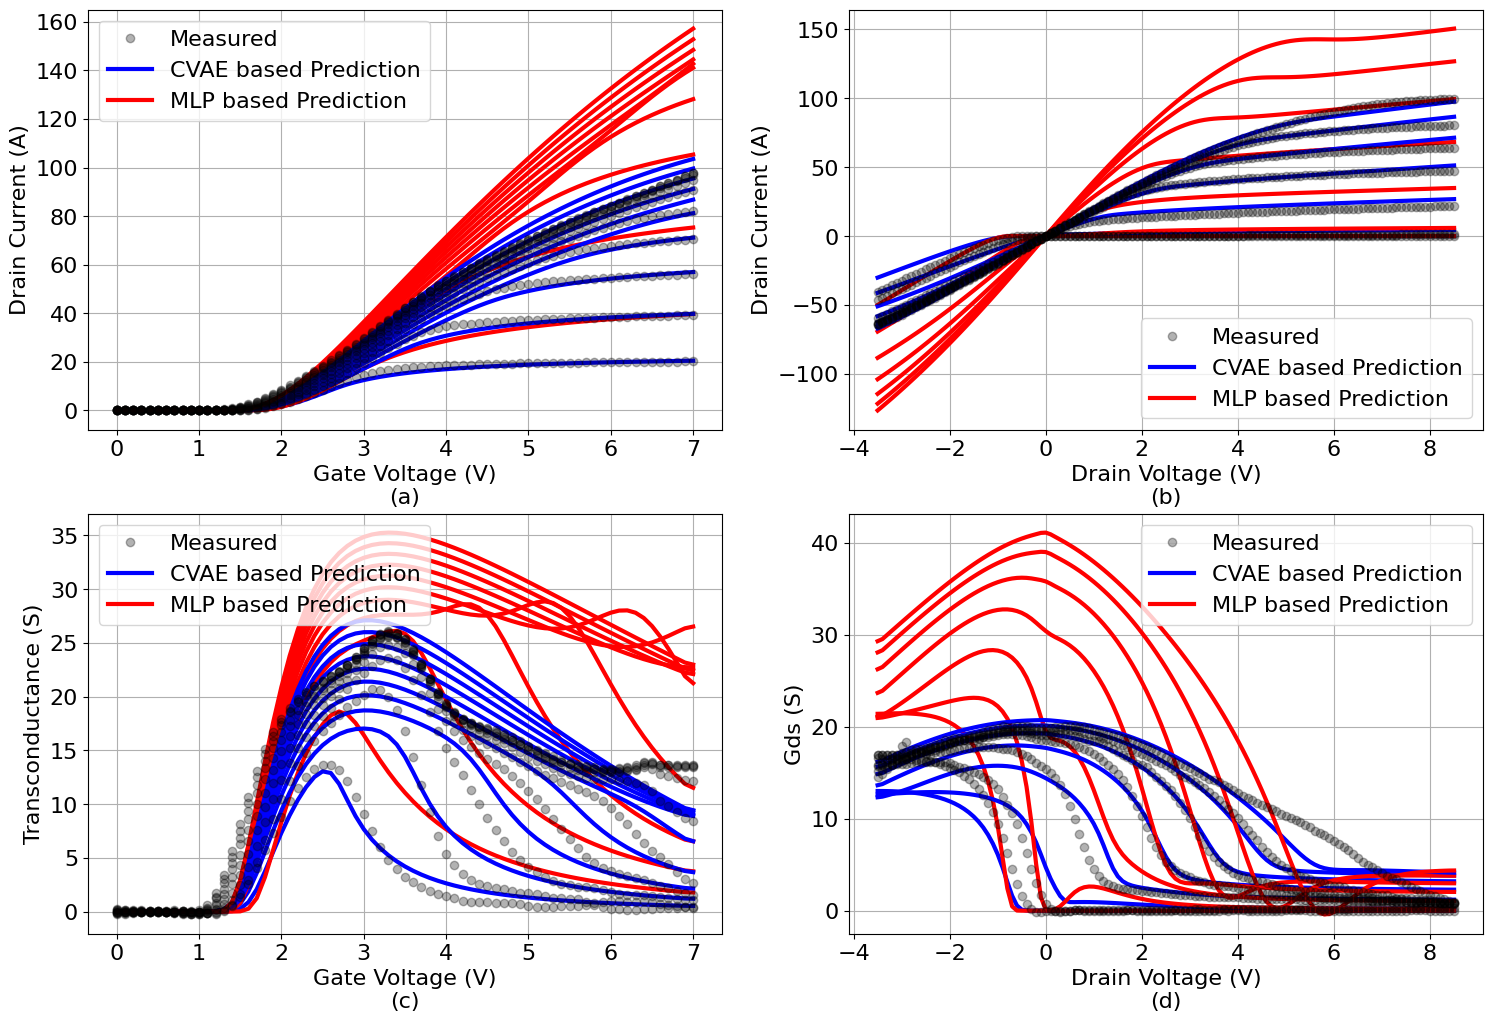

In [9]:
# fig 3.5 :: better result representation (mlp + cvae + meas)

four_fig_plus_mlp_plot(X_origin_o, X_origin_t, X_pred, X_pred_mlp, vgs_bias_x_axis, vds_bias_x_axis, size=(18,12),fontsize=16)


size of measured Output feature:  (1, 7, 121)
size of measured Transfer feature:  (1, 10, 71)
size of predicted Output feature:  (1, 7, 121)
size of predicted Transfer feature:  (1, 10, 71)
saved figure under path : C:\Users\97427\Desktop\figure.svg 


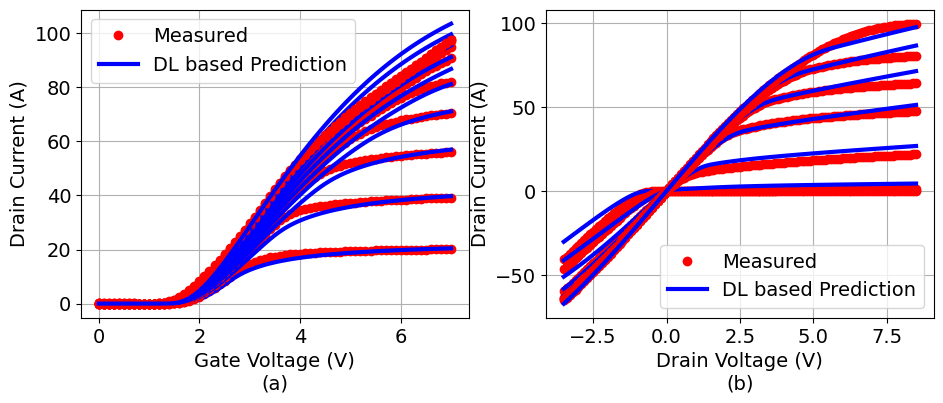

In [21]:
# fig 4 :: better result representation (2 figure version)

two_fig_plot(X_origin_o, X_origin_t, X_pred, vgs_bias_x_axis, vds_bias_x_axis, size=(11,4),fontsize=14)

In [ ]:
import pandas as pd

df = pd.DataFrame(var_dict)
df.to_csv("C:\\Users\\97427\\Desktop\\output_prob.csv", index=False)
# print(var_dict)

In [ ]:
print(X_origin_o['X'].shape)
print(X_origin_t['X'].shape)
print(X_pred_mlp['X_iv'].shape)
print(X_pred_mlp['X_gm'].shape) 
print(X_pred['X_iv'].shape)
print(X_pred['X_gm'].shape)

data = {
    "meas_data_output": X_origin_o['X'][:],
    "meas_data_transfer": X_origin_t['X'][:],
    "pred_data_mlp_output": X_pred_mlp['X_iv'][:],
    "pred_data_mlp_transfer": X_pred_mlp['X_gm'][:],
    "pred_data_cvae_output": X_pred['X_iv'][:],
    "pred_data_cvae_transfer": X_pred['X_gm'][:]
}

with h5py.File("C:\\Users\\97427\\Desktop\\data.h5", "w") as f:
    for k, v in data.items():
        f.create_dataset(k, data=v)

(1, 7, 121)
(1, 10, 71)
(1, 7, 121)
(1, 10, 71)
(1, 7, 121)
(1, 10, 71)


In [32]:
with h5py.File("C:\\Users\\97427\\Desktop\\data.h5", "r") as f:
    print(f.keys())

<KeysViewHDF5 ['meas_data_output', 'meas_data_transfer', 'pred_data_cvae_output', 'pred_data_cvae_transfer', 'pred_data_mlp_output', 'pred_data_mlp_transfer']>
